In [16]:
from typing import List, Tuple

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
sys.path.append("../")
import util
import importlib
importlib.reload(util)

from util import util_functions
from util.util_functions import PreprocessInfo
from util.util_functions import ClusteringExperiment

px = 1/plt.rcParams["figure.dpi"]
plt.rcParams['figure.figsize'] = [1848*px, 965*px]
c = [
    "#007fff",  # Blue
    "#ff3616",  # Red
    "#138d75",  # Green
    "#7d3c98",  # Purple
    "#fbea6a",  # Yellow
]
sns.set(
    style="ticks",
    rc={
        "font.family": "Arial",
        "font.size": 40,
        "axes.linewidth": 2,
        "lines.linewidth": 5,
    },
    font_scale=2.5,
    palette=sns.color_palette("Set2")
)

CONDUCTANCE_LABEL = r"Conductance (log$_{10}$(G/G$_0$))"
ALPHABET = "ABCDEFGHIJKLMNOPQ"
RNG_STATE = 43
FONTSIZE = 48

In [17]:
pre_info = PreprocessInfo(
    high=-.5,
    low=-6,
    plot_high=-.5,
    plot_low=-6,
    bins=128,
    bins_2d=(64, 64),
    hist2d_length=2048,
)

In [18]:
def read_csv(csv_file: str):
    import csv
    data = []
    with open(csv_file, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            tmp = []
            for item in row:
                tmp.append(float(item))
            data.append(np.array(tmp))
            
    return np.array(data)

traces = read_csv("./4k_bpy_all_traces.csv")

# traces = np.load("all_traces.npy", allow_pickle=True)
labels = np.genfromtxt("../../../machine/andras_bp/Labels.txt")
full_traces, processed_traces, labels = util_functions.preprocess_4k_data(traces, labels, pre_info)
labels[labels == 0] = -1
labels *= -1

full_hists, full_hists2d = util_functions.get_histograms(full_traces, low=pre_info.plot_low, high=pre_info.plot_high, pre_info=pre_info)
hists, hists2d = util_functions.get_histograms(processed_traces, low=pre_info.low, high=pre_info.high, pre_info=pre_info)

Processing traces:   0%|          | 0/5475 [00:00<?, ?it/s]/home/william/workspace/git/one_class_smbj/4k_bpy/../util/util_functions.py:53: RuntimeWarning: invalid value encountered in log10
  trace = np.log10(trace)
Processing traces: 100%|██████████| 5475/5475 [00:00<00:00, 13388.57it/s]


Longest trace: 1630
Amount discarded: 19


Generating 1D- and 2D histograms: 100%|██████████| 5082/5082 [00:01<00:00, 3648.03it/s]


In [19]:
print(f"Amount of blank traces: {len(labels[labels == 1])}")
print(f"Amount of molecular traces: {len(labels[labels == -1])}")

Amount of blank traces: 3219
Amount of molecular traces: 1863


Generating 2D histograms: 100%|██████████| 1863/1863 [00:00<00:00, 3905.44it/s]


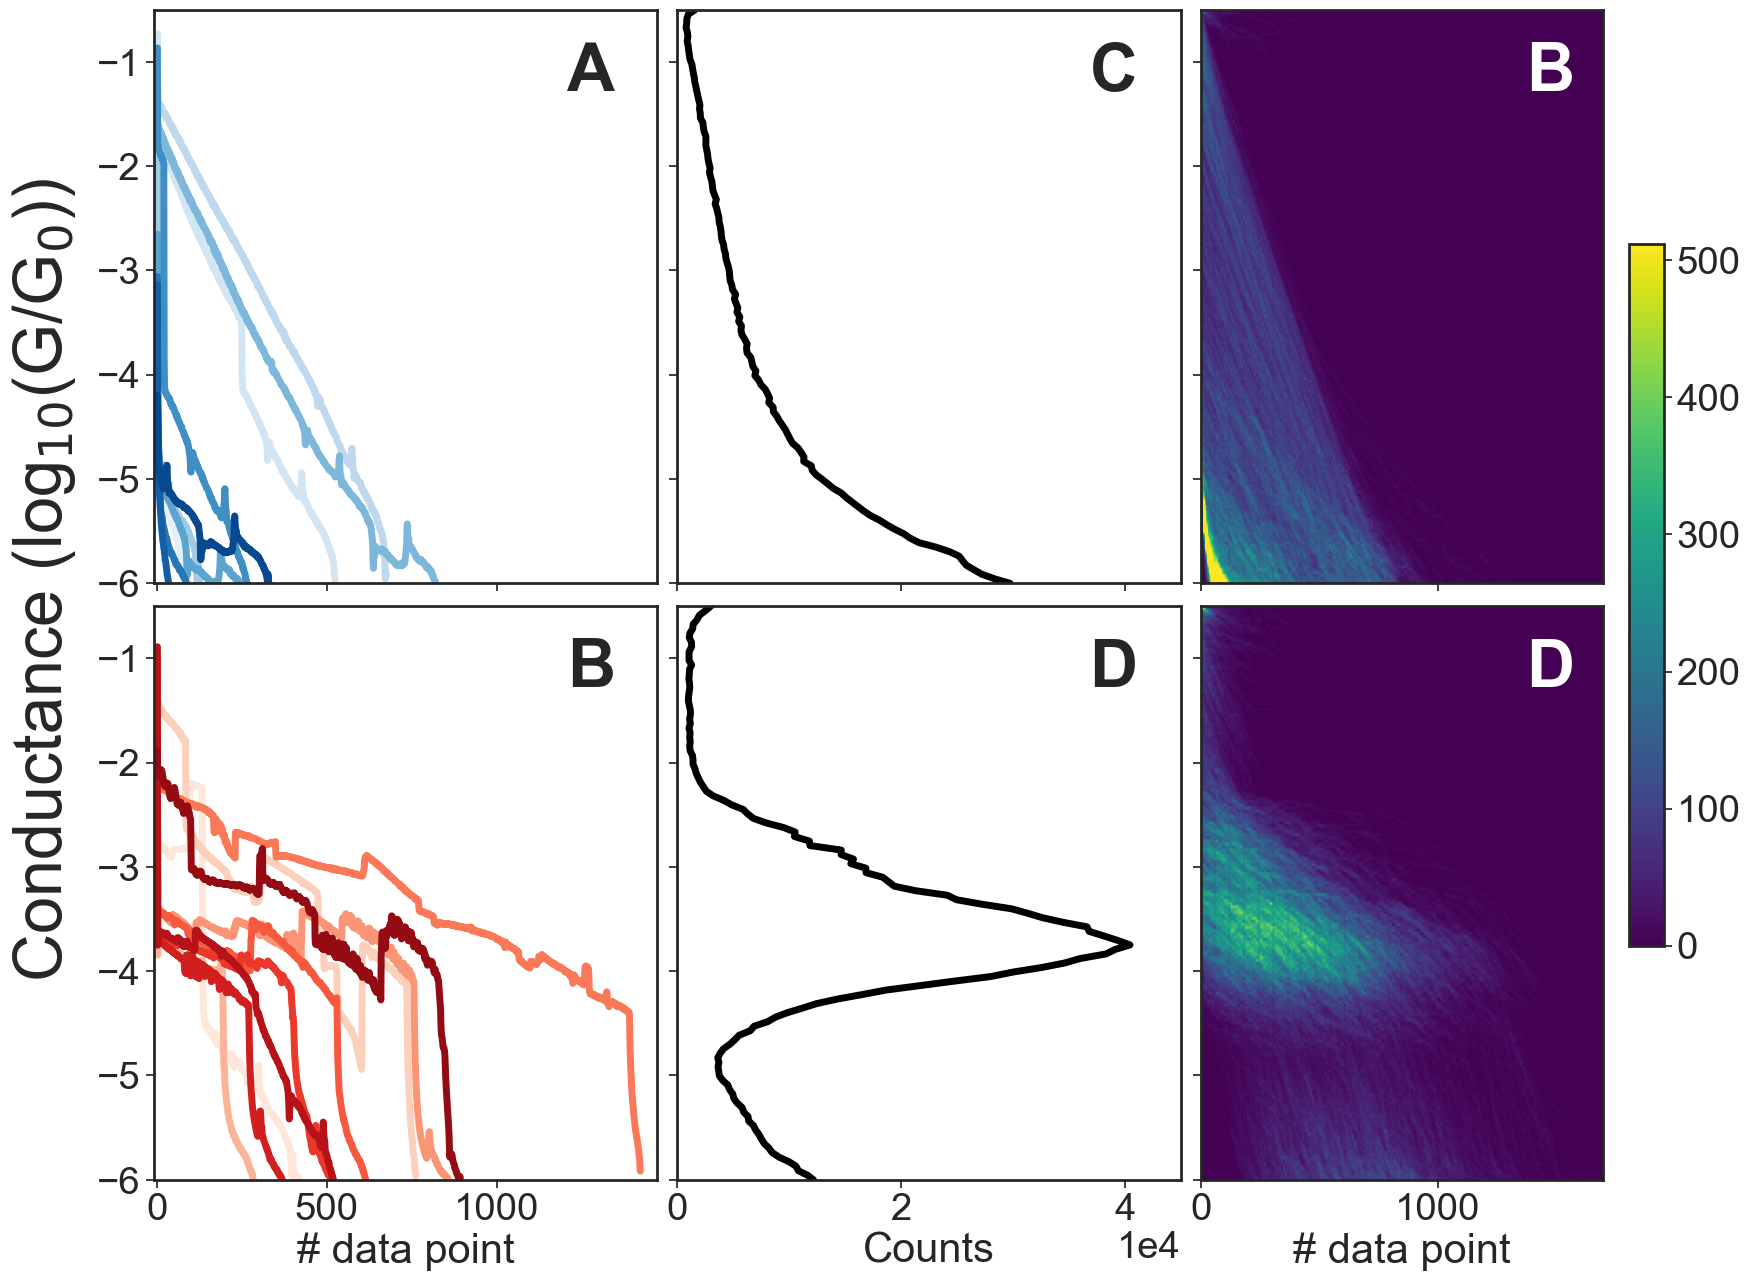

In [20]:
rng = np.random.default_rng(RNG_STATE)
text_height = -1.1
blues = sns.color_palette("Blues", 10)
reds = sns.color_palette("Reds", 10)
colors = [blues, reds]

# Visualization of both parts of the data set
fig, ax = plt.subplots(2, 3, figsize=(20, 30))
for idx, (dataset_hists, dataset_traces) in enumerate(
    [
        [full_hists[labels == 1], full_traces[labels == 1]],
        [full_hists[labels == -1], full_traces[labels == -1]],
    ]
):
    max_length = 0
    for c_i, trace in enumerate(dataset_traces[rng.integers(0, len(dataset_traces), size=10)]):
        ax[idx, 0].plot(trace, c=colors[idx][c_i])
        if len(trace) > max_length:
            max_length = len(trace)
    ax[idx, 0].set_ylim(pre_info.plot_low, pre_info.plot_high)
    ax[idx, 0].set_xlim(-10, 1024 + 450)
    ax[idx, 0].text(1024 + 256, text_height, ALPHABET[idx], va="center", ha="center", weight="bold", size=FONTSIZE)
    
    ax[idx, 1].plot(
        dataset_hists.sum(axis=0), np.linspace(pre_info.plot_low, pre_info.plot_high, dataset_hists.shape[1]), c="k"
    )
    ax[idx, 1].set_xlim(0, 4.5e4)
    ax[idx, 1].set_ylim(pre_info.plot_low, pre_info.plot_high)
    ax[idx, 1].text(3.9e4, text_height, ALPHABET[idx + 2], va="center", ha="center", weight="bold", size=FONTSIZE)

    hist_2d = []
    bins_2d = 128 + 64
    hist_2d = np.zeros((bins_2d, bins_2d))

    # without alignment
    # ============================
    vmax = 512
    for trace in tqdm(dataset_traces, desc="Generating 2D histograms"):
        H, *_ = np.histogram2d(
            trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [0, 1700]]
        )
        hist_2d += H

    im = ax[idx, 2].imshow(
        hist_2d,
        vmin=0,
        vmax=vmax,
        origin="lower",
        cmap="viridis",
        extent=[0, 1700, pre_info.plot_low, pre_info.plot_high],
        aspect="auto",
    )
    ax[idx, 2].text(
        1024 + 450, text_height, ALPHABET[idx*2 + 1], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )
    # ============================

    # with alignment
    # ============================
    # vmax = 512 + 256
    # crossovers = []
    # for trace in dataset_traces:
    #     co = np.argwhere(trace < -5)
    #     if len(co) > 1:
    #         crossovers.append(co[0][0])
    #     else:
    #         crossovers.append(len(trace))
    # max_co = np.max(crossovers)
    # for trace, co in zip(dataset_traces, crossovers):
    #     embedded = np.zeros(len(trace) + max_co)
    #     embedded[max_co - co:(max_co - co) + len(trace)] = trace
    #     H, *_ = np.histogram2d(embedded, np.arange(len(embedded)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [0, 1700]])
    #     hist_2d += H
    # im = ax[idx, 2].imshow(
    #     hist_2d, vmin=0, vmax=vmax, origin="lower", cmap="viridis", extent=[0, 1700, pre_info.plot_low, pre_info.plot_high], aspect="auto"
    # )
    # ax[idx, 2].text(1024 + 430, text_height, ALPHABET[idx + 4], va="center", ha="center", weight="bold", size=FONTSIZE, c="white")
    # ============================
    
    if idx == 0:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
        ax[idx, 2].set_xticklabels([])

    ax[idx, 1].set_yticklabels([])
    ax[idx, 2].set_yticklabels([])
    if idx == 1:
        ax[idx, 0].set_xlabel("# data point")
        ax[idx, 1].set_xlabel("Counts")
        ax[idx, 2].set_xlabel("# data point")
        ax[idx, 1].ticklabel_format(axis="x", scilimits=[-5, 4])

fig.text(0.07, 0.31, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)
fig.subplots_adjust(wspace=0.04, top=0.5, hspace=0.04)
fig.colorbar(im, ax=ax[:, 2], shrink=.6)
fig.savefig("labeled_hists.pdf")
plt.show()

In [21]:
from sklearn.svm import OneClassSVM
from sklego.mixture import GMMOutlierDetector
# from pyod.models.auto_encoder import AutoEncoder
# from pyod.models.deep_svdd import DeepSVDD
# from pyod.models.vae import VAE

model_ocsvm_linear = OneClassSVM(kernel="linear", nu=0.01, gamma="scale")
model_ocsvm_rbf = OneClassSVM(kernel="rbf", nu=0.01, gamma="scale")
model_gmm_1comp = GMMOutlierDetector(n_components=1, threshold=0.99, random_state=RNG_STATE)
model_gmm_3comp = GMMOutlierDetector(n_components=3, threshold=0.99, random_state=RNG_STATE)

# deep learning models
# epochs = 16
# model_simple_ae = AutoEncoder(epochs=epochs, hidden_activation="relu", contamination=0.01, random_state=RNG_STATE)
# model_deepsvdd = DeepSVDD(use_ae=True, epochs=epochs, hidden_activation="relu", contamination=0.01, random_state=RNG_STATE)
# model_deepsvdd_noae = DeepSVDD(use_ae=False, epochs=epochs, hidden_activation="relu", contamination=0.01, random_state=RNG_STATE)
# model_vae = VAE(epochs=epochs, gamma=0.8, hidden_activation="relu", contamination=0.01, random_state=RNG_STATE)

models = [
    model_ocsvm_linear,
    model_ocsvm_rbf,
    model_gmm_1comp,
    model_gmm_3comp,
    
    # model_simple_ae,
    # model_deepsvdd,
    # model_deepsvdd_noae,
    # model_vae,
]

names = [
    "OC-SVM (Linear)",
    "OC-SVM (RBF)",
    "GMM (1 comp.)",
    "GMM (3 comp.)",

    # "Simple AE",
    # "Deep SVDD",
    # "Deep SVDD (No pretraining)",
    # "VAE",
]

In [22]:
from sklearn import metrics
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, random_state=RNG_STATE, shuffle=True)

# crossvalidate the performance of each model

avg_fpr, avg_tpr = [], []
auc = []
mean_fpr = np.linspace(0, 1, 100)
for model in tqdm(models):
    avg_acc, avg_roc_auc, avg_fm = [], [], []
    tmp_tpr = []
    for idx, (train_indices, test_indices) in enumerate(kfold.split(hists)):
        train_labels = labels[train_indices]
        test_labels = labels[test_indices]
        train_subset = hists[train_indices][train_labels == 1]
        test = hists[test_indices]

        model.fit(train_subset)

        pred_labels = model.predict(test)

        pred_scores = model.decision_function(test)

        if hasattr(model, "kernel"):
            if model.kernel == "linear":
                test_labels *= -1

        if model.__class__.__name__ in ["AutoEncoder", "VAE", "DeepSVDD"]:
            test_labels[test_labels == 1] = 0
            test_labels[test_labels == -1] = 1
        
        avg_acc.append(
            metrics.accuracy_score(
                test_labels,
                pred_labels,
            )
        )
        avg_fm.append(
            metrics.fowlkes_mallows_score(
                test_labels,
                pred_labels,
            )
        )
        if model.__class__.__name__ in ["GMMOutlierDetector"]:
            test_labels *= -1
        avg_roc_auc.append(
            metrics.roc_auc_score(
                test_labels,
                pred_scores,
            )
        )

        fpr, tpr, _ = metrics.roc_curve(test_labels, pred_scores)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tmp_tpr.append(interp_tpr)
    avg_tpr.append(tmp_tpr)
    auc.append(np.mean(avg_roc_auc))
    tmp_tpr = []

    print(f"Average accuracy for {model.__class__.__name__}: {np.mean(avg_acc)*100:.3} ± {np.std(avg_acc, ddof=1)*100:.3}")
    print(f"Average Fowlkes-Mallows for {model.__class__.__name__}: {np.mean(avg_fm)*100:.3} ± {np.std(avg_fm, ddof=1)*100:.3}")
    print(f"Average ROC AUC for {model.__class__.__name__}: {np.mean(avg_roc_auc)*100:.3} ± {np.std(avg_roc_auc, ddof=1)*100:.3}")
    print("="*25)

 25%|██▌       | 1/4 [00:00<00:00,  6.45it/s]

Average accuracy for OneClassSVM: 37.4 ± 2.4
Average Fowlkes-Mallows for OneClassSVM: 72.4 ± 0.968
Average ROC AUC for OneClassSVM: 53.0 ± 4.11


 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

Average accuracy for OneClassSVM: 95.4 ± 0.502
Average Fowlkes-Mallows for OneClassSVM: 91.7 ± 0.91
Average ROC AUC for OneClassSVM: 99.1 ± 0.225


 75%|███████▌  | 3/4 [00:02<00:00,  1.08it/s]

Average accuracy for GMMOutlierDetector: 95.5 ± 0.805
Average Fowlkes-Mallows for GMMOutlierDetector: 92.1 ± 1.41
Average ROC AUC for GMMOutlierDetector: 98.9 ± 0.186


100%|██████████| 4/4 [00:07<00:00,  1.87s/it]

Average accuracy for GMMOutlierDetector: 95.2 ± 0.739
Average Fowlkes-Mallows for GMMOutlierDetector: 91.5 ± 1.36
Average ROC AUC for GMMOutlierDetector: 98.1 ± 0.346


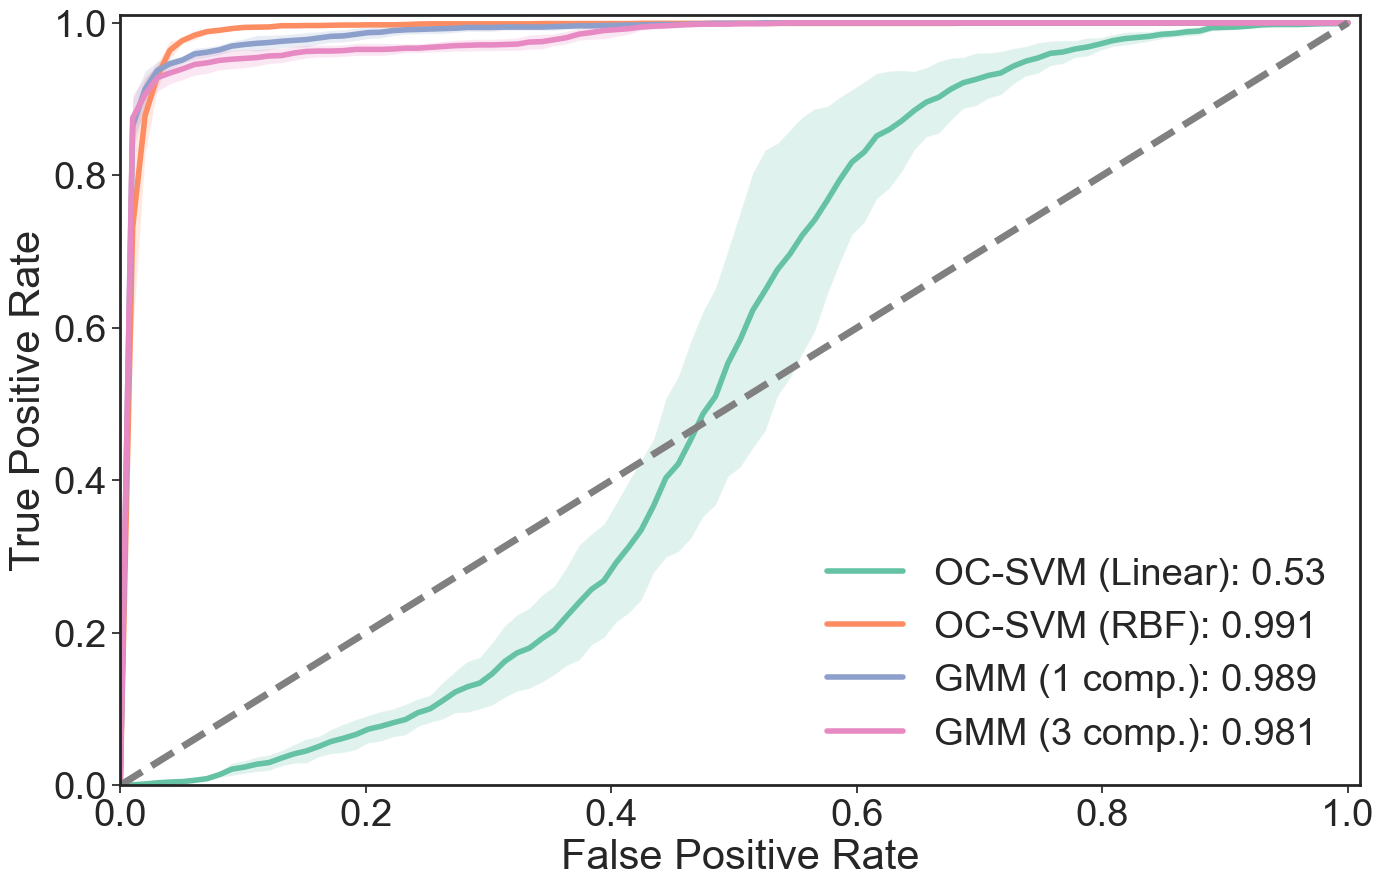

In [23]:
fig, ax = plt.subplots(figsize=(16,10))
for tprs, avg_auc, name in zip(avg_tpr, auc, names):
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    std_tpr = np.std(tprs, ddof=1, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        alpha=0.2,
    )
    ax.plot(mean_fpr, mean_tpr, label=f"{name}: {avg_auc:.3}", linewidth=4)
ax.plot([0, 1], [0, 1], linestyle="--", c="grey")

ax.set_ylim(0, 1.01)
ax.set_xlim(0, 1.01)

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(frameon=False, ncol=1)
fig.savefig("./4k_labelled_rocauc.pdf")
plt.show()

In [24]:
def plot_2dhist(pred_labels: List[int], tunneling_label: int, bins_2d: Tuple[int, int], hist2d_length: int, ax): 
    hist_2d = []
    crossovers = []
    for trace in full_traces[pred_labels == tunneling_label]:
        co = np.argwhere(trace < -5)
        if len(co) > 1:
            crossovers.append(co[0][0])
        else:
            crossovers.append(len(trace))
    max_co = np.max(crossovers)
    print(max_co)
    max_co = 1465
    max_co = 1545

    hist_2d = np.zeros(bins_2d)
    for trace, co in zip(full_traces[pred_labels == tunneling_label], crossovers):
        embedded = np.zeros(len(trace) + max_co)
        embedded[max_co - co:(max_co - co) + len(trace)] = trace
        H, *_ = np.histogram2d(
            embedded, np.arange(len(embedded)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [512, hist2d_length]]
        )
        hist_2d += H
    im = ax.imshow(
        hist_2d, vmin=0, vmax=512 + 256, origin="lower", cmap="viridis", extent=[512, hist2d_length, pre_info.plot_low, pre_info.plot_high], aspect="auto"
    )
    return im

Fowlkes-mallows for OneClassSVM: 72.6
Accuracy for OneClassSVM: 37.2
Amount predicted tunneling: 33
147
Fowlkes-mallows for OneClassSVM: 94.4
Accuracy for OneClassSVM: 96.9
Amount predicted tunneling: 3170
871
Fowlkes-mallows for GMMOutlierDetector: 92.6
Accuracy for GMMOutlierDetector: 95.8
Amount predicted tunneling: 3349
871
Fowlkes-mallows for GMMOutlierDetector: 93.8
Accuracy for GMMOutlierDetector: 96.6
Amount predicted tunneling: 3296
871


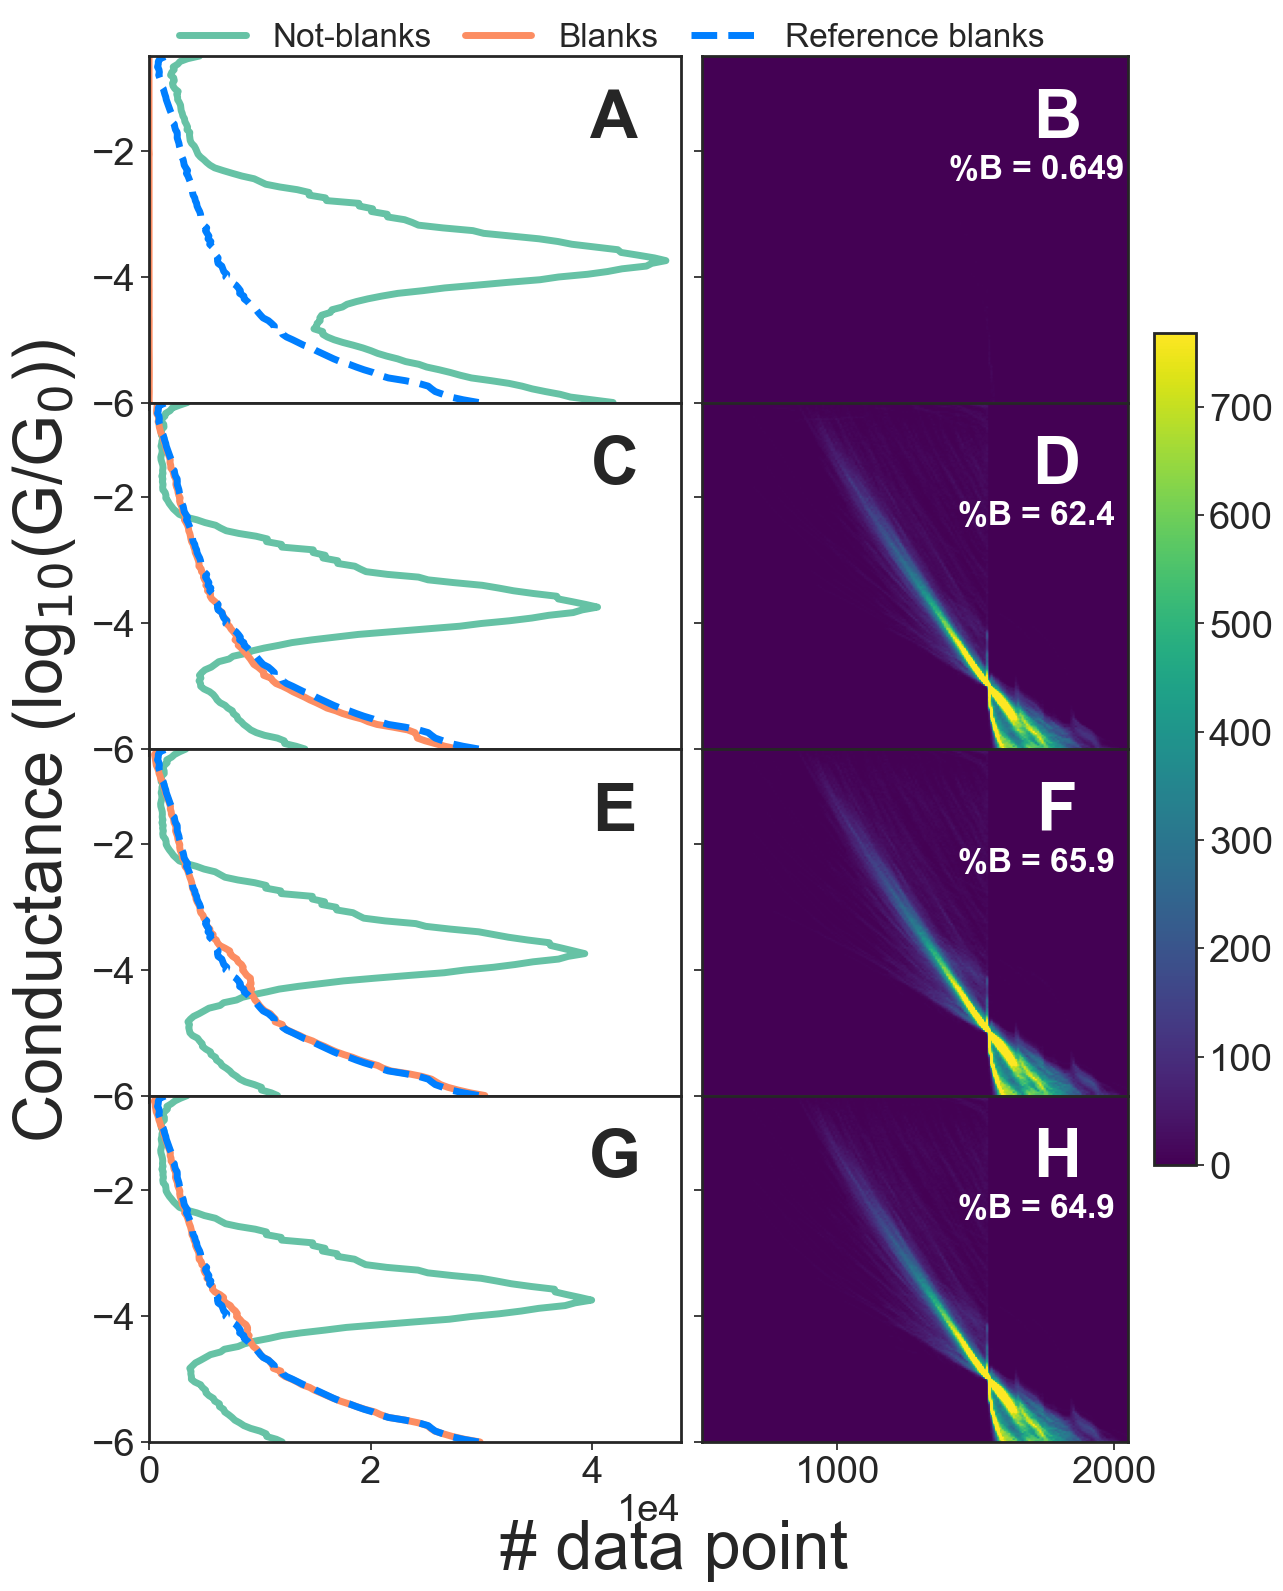

In [25]:
from sklearn import metrics


def plot_traces(traces: np.ndarray, cmap: str, ax) -> None:
    cmap = sns.color_palette(cmap, len(traces))
    for idx, trace in enumerate(traces):
        ax.plot(trace, c=cmap[idx])

px = 1/plt.rcParams["figure.dpi"]
fig, ax = plt.subplots(len(models), 2, figsize=(14, 18))  # 26

ax1_yaxis = np.linspace(pre_info.plot_low, pre_info.plot_high, pre_info.bins)
hist2d_length = 2048
max_ax1 = 0
percentages = []
for idx, model in enumerate(models):
    pred_labels = model.predict(hists)

    if model.__class__.__name__ in ["AutoEncoder", "VAE", "DeepSVDD"]:
        pred_labels[pred_labels == 0] = -1
        pred_labels *= -1

    # linear ocsvm has switched the pred_labels
    if model.__class__.__name__ == "OneClassSVM":
        if model.get_params()["kernel"] == "linear":
            pred_labels *= -1
    print(
        f"Fowlkes-mallows for {model.__class__.__name__}: {metrics.fowlkes_mallows_score(labels, pred_labels)*100:.3}"
    )
    print(
        f"Accuracy for {model.__class__.__name__}: {metrics.accuracy_score(labels, pred_labels)*100:.3}"
    )

    pred_mol = full_hists[pred_labels == -1]
    ax[idx, 0].plot(
        pred_mol.sum(axis=0),
        ax1_yaxis,
        label=f"Not-blanks" if idx == 0 else "_"
    )
    pred_tun = full_hists[pred_labels == 1]
    ax[idx, 0].plot(
        pred_tun.sum(axis=0),
        ax1_yaxis,
        label=f"Blanks" if idx == 0 else "_"
    )
    print(f"Amount predicted tunneling: {len(pred_tun)}")
    percentages.append(1.0 - (len(full_hists) - len(pred_tun))/len(full_hists))


    ax[idx, 0].plot(
        full_hists[labels == 1].sum(axis=0),
        ax1_yaxis,
        c=c[0],
        linestyle="--",
        label="Reference blanks" if idx == 0 else "_",
    )
    im = plot_2dhist(pred_labels, 1, (128 + 64, 128 + 64), hist2d_length=hist2d_length, ax=ax[idx, 1])

    if np.max(pred_mol.sum(axis=0)/len(pred_mol)) > max_ax1:
        max_ax1 = np.max(pred_mol.sum(axis=0)/len(pred_mol))
    
    if not idx == len(models) - 1:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
    ax[idx, 1].set_yticklabels([])
    ax[idx, 0].set_ylim(pre_info.plot_low, pre_info.plot_high)
ax[0, 0].legend(frameon=False, loc="lower left", bbox_to_anchor=(0.0, 0.92, 1, 0), ncol=3, columnspacing=1., fontsize=FONTSIZE//2)

for idx, p in zip(np.arange(len(models)), percentages):
    ax[idx, 0].text(42_000, -1.5, ALPHABET[idx*2], va="center", ha="center", size=FONTSIZE, weight="bold")
    ax[idx, 1].text(
        2048 - 256, -1.5, ALPHABET[idx*2 + 1], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )
    ax[idx, 1].text(hist2d_length - 256 - 64 - 8, text_height - 1.2, f"%B = {p*100:.3}", va="center", ha="center", fontsize=FONTSIZE // 2, c="white", weight="bold")


    ax[idx, 0].set_xlim(0, 48_000)
    # ax[idx, 0].set_xlim(0, max_ax1 + max_ax1*0.05)
ax[idx, 0].ticklabel_format(axis="x", scilimits=[-5, 4])

fig.text(0.5, 0.05, "# data point", va="center", ha="center", fontsize=FONTSIZE)
fig.text(0.05, 0.5, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)
fig.subplots_adjust(hspace=0.0, wspace=0.04)
fig.colorbar(im, ax=ax[:, 1], shrink=.6)
plt.savefig("./4k_visual_perf.pdf")
plt.show()

In [26]:
length_range = (0, 1024 + 256)
length_bins = 128

100%|██████████| 4/4 [00:00<00:00, 28.73it/s]


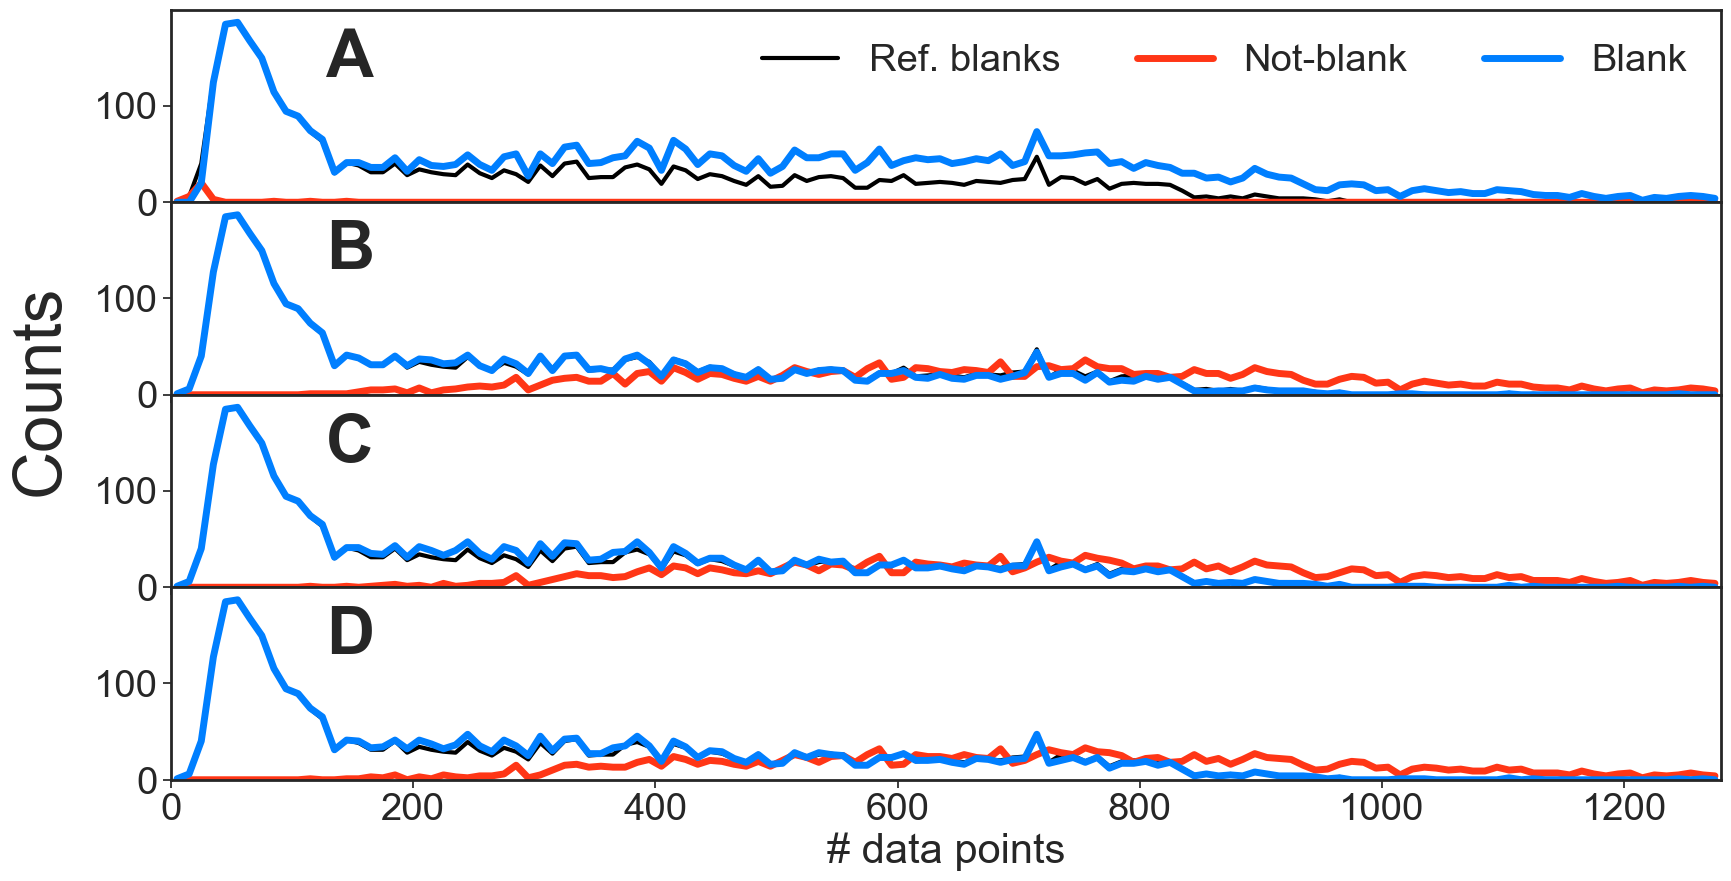

In [27]:
fig, ax = plt.subplots(4, 1, figsize=(20, 10), sharex=True, sharey=True)
pal = sns.color_palette("Set2", 12)

len_ref = np.histogram([len(x) for x in processed_traces[labels == 1]], bins=length_bins, range=length_range)[0]
for idx, model in enumerate(tqdm(models)):
    pred_labels = model.predict(hists)

    len_mol, binedges = np.histogram([len(x) for x in processed_traces[pred_labels == -1]], bins=length_bins, range=length_range)
    len_tun = np.histogram([len(x) for x in processed_traces[pred_labels == 1]], bins=length_bins, range=length_range)[0]

    binedges = (binedges[1:] + binedges[:-1])/2
    ax[idx].plot(binedges, len_ref, label="Ref. blanks", c="k", lw=3)
    ax[idx].plot(binedges, len_mol, label="Not-blank", c=c[1])
    ax[idx].plot(binedges, len_tun, label="Blank", c=c[0])
    ax[idx].text(128, 130, ALPHABET[idx], fontsize=FONTSIZE, weight="bold")
ax[0].legend(frameon=False, ncol=3)
plt.xlim(length_range)
plt.ylim(0, 199)
plt.xlabel("# data points")
fig.text(0.06, 0.5, "Counts", va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)

fig.subplots_adjust(hspace=0.0)
fig.savefig("length_distributions.pdf")
plt.show()

EXPERIMENT - NONFILTERED DATA
Generating feature sets..
Instantiating models..


  0%|          | 0/5 [00:00<?, ?it/s]

Analysis from GMM MEA
Amount of traces in 1: 2831
Amount of traces in 2: 2251


 40%|████      | 2/5 [00:03<00:05,  1.73s/it]

Analysis from KMeans MEA - mixed
Amount of traces in 1: 3932
Amount of traces in 2: 1150


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

Analysis from KMeans MEA - 28x28
Amount of traces in 1: 1531
Amount of traces in 2: 3551


 80%|████████  | 4/5 [00:12<00:03,  3.43s/it]

Analysis from Spectral Wenjing - 300
Amount of traces in 1: 2122
Amount of traces in 2: 2960


100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

Analysis from Spectral Wenjing - 900
Amount of traces in 1: 2016
Amount of traces in 2: 3066


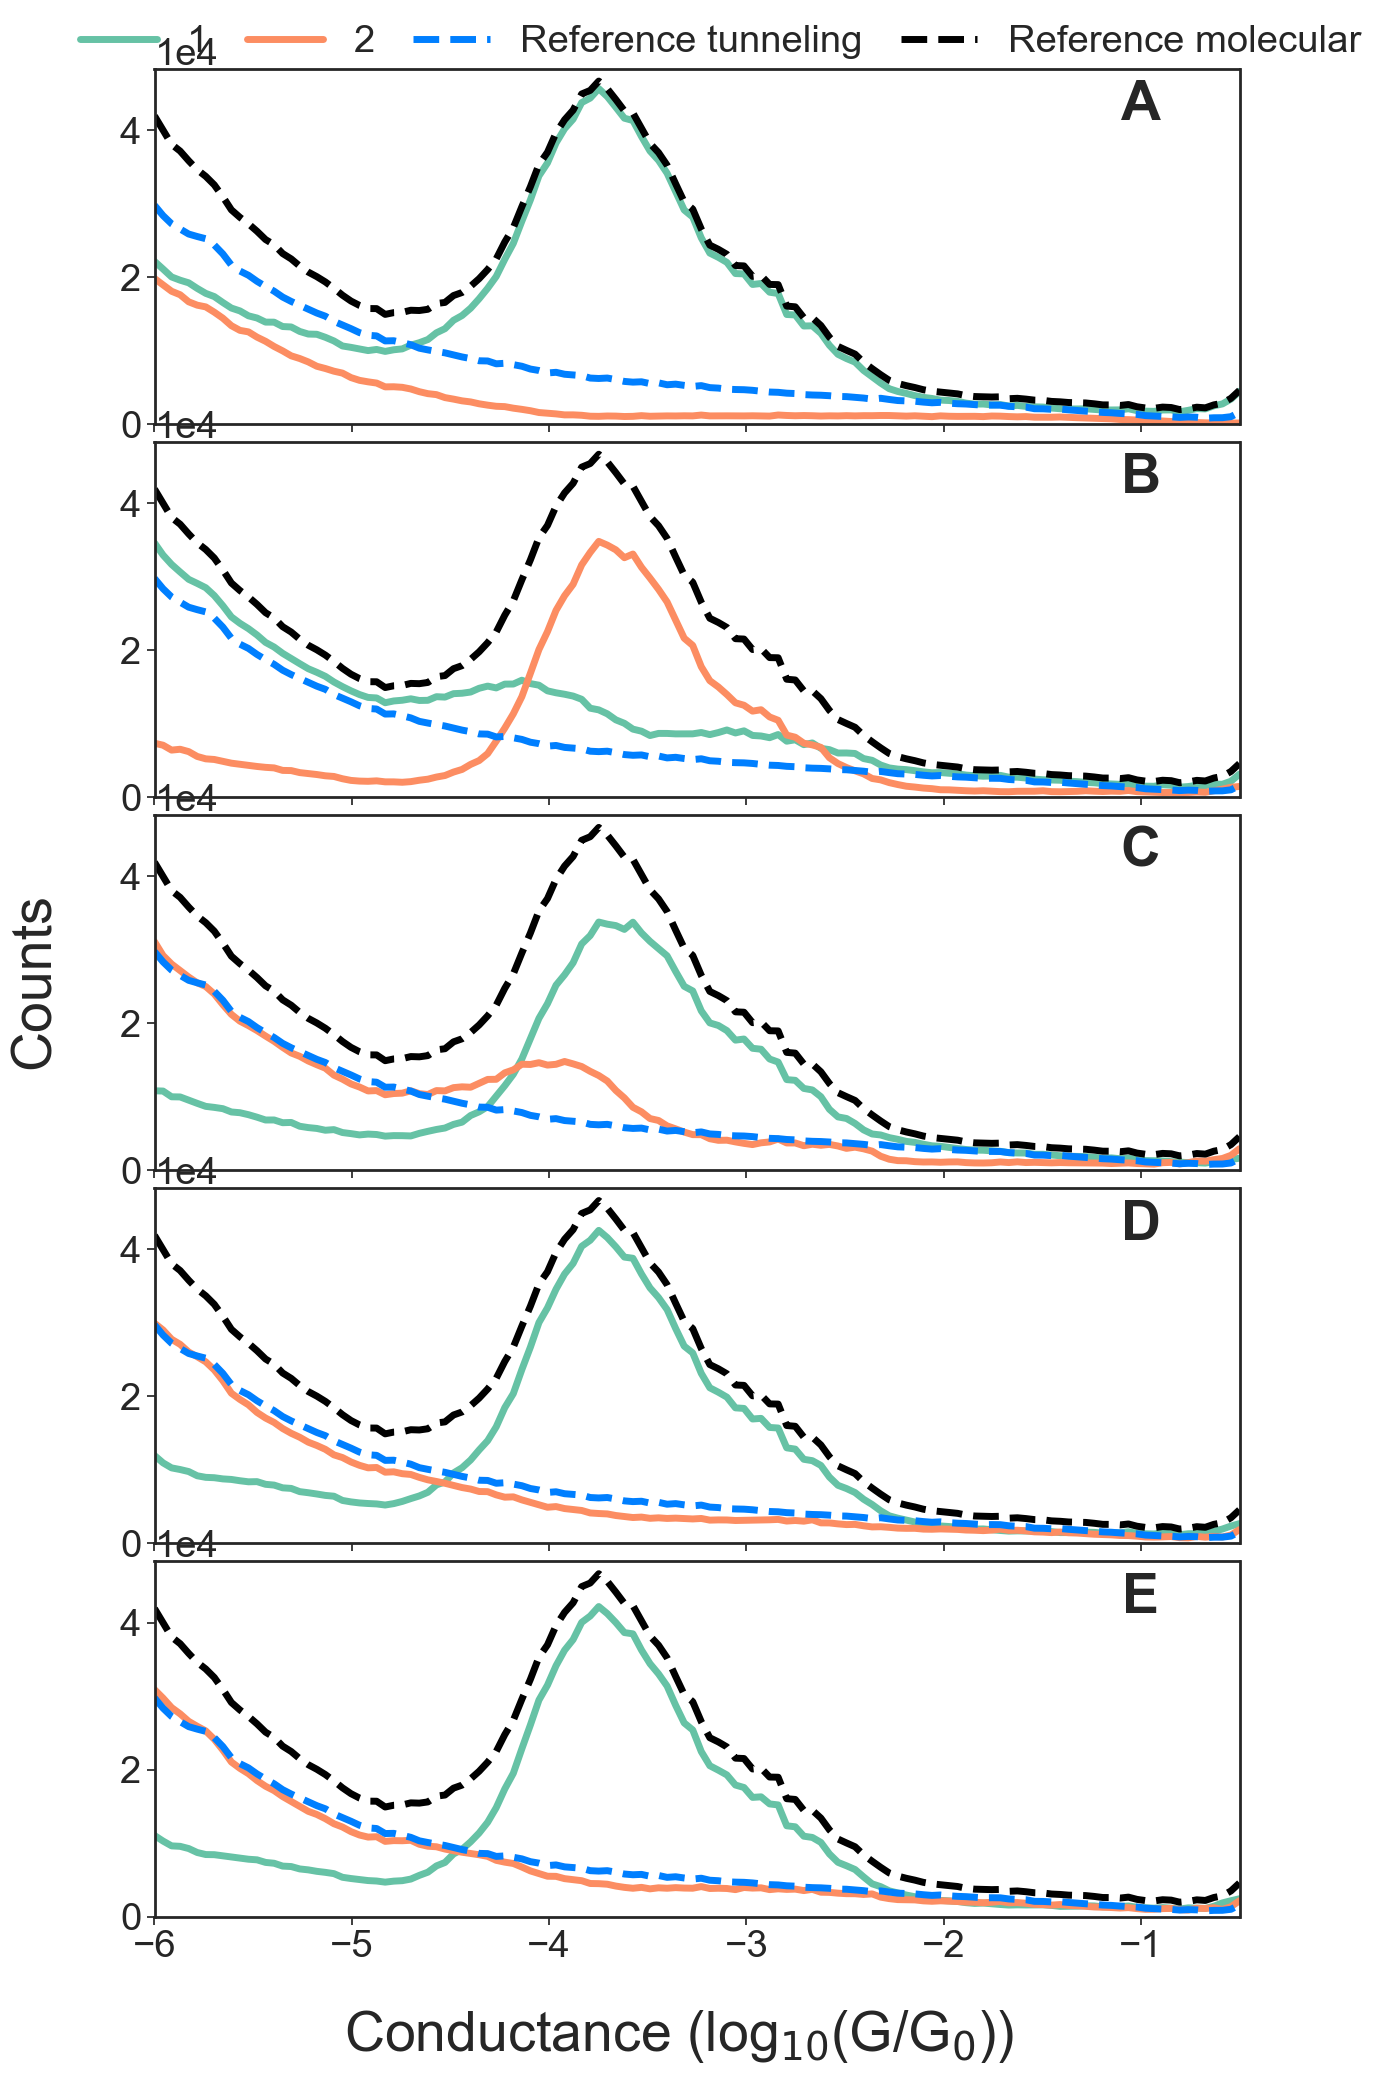

In [28]:
print("EXPERIMENT - NONFILTERED DATA")
experiment = ClusteringExperiment(
    raw_molecular=processed_traces,
    default_molecular_hists=hists,
    default_blank_hists=hists[labels == 1],
    mea_bins=100,
    rng_seed=RNG_STATE,
)
print("Generating feature sets..")
experiment.generate_feature_sets(low=-5, high=-0.5)

for n in np.arange(2, 3):
    print("Instantiating models..")
    cluster_models = experiment.instantiate_models(n_clusters=n)

    fig, ax, cluster_labels = experiment.plot_clustering_results(
        cluster_models=cluster_models, plt_low=-6, plt_high=-0.5
    )
    np.save(f"./cluster_labels_data_{n}.npy", cluster_labels)

In [29]:
cluster_labels = np.load("./cluster_labels_data_2.npy")

982
Amount predicted blanks: 2251
Fowlkes-mallows: 69.6
Accuracy: 80.3
1229
Amount predicted blanks: 3932
Fowlkes-mallows: 79.9
Accuracy: 85.9
1545
Amount predicted blanks: 3551
Fowlkes-mallows: 70.3
Accuracy: 79.0
982
Amount predicted blanks: 2960
Fowlkes-mallows: 82.7
Accuracy: 89.9
1011
Amount predicted blanks: 3066
Fowlkes-mallows: 82.8
Accuracy: 89.9


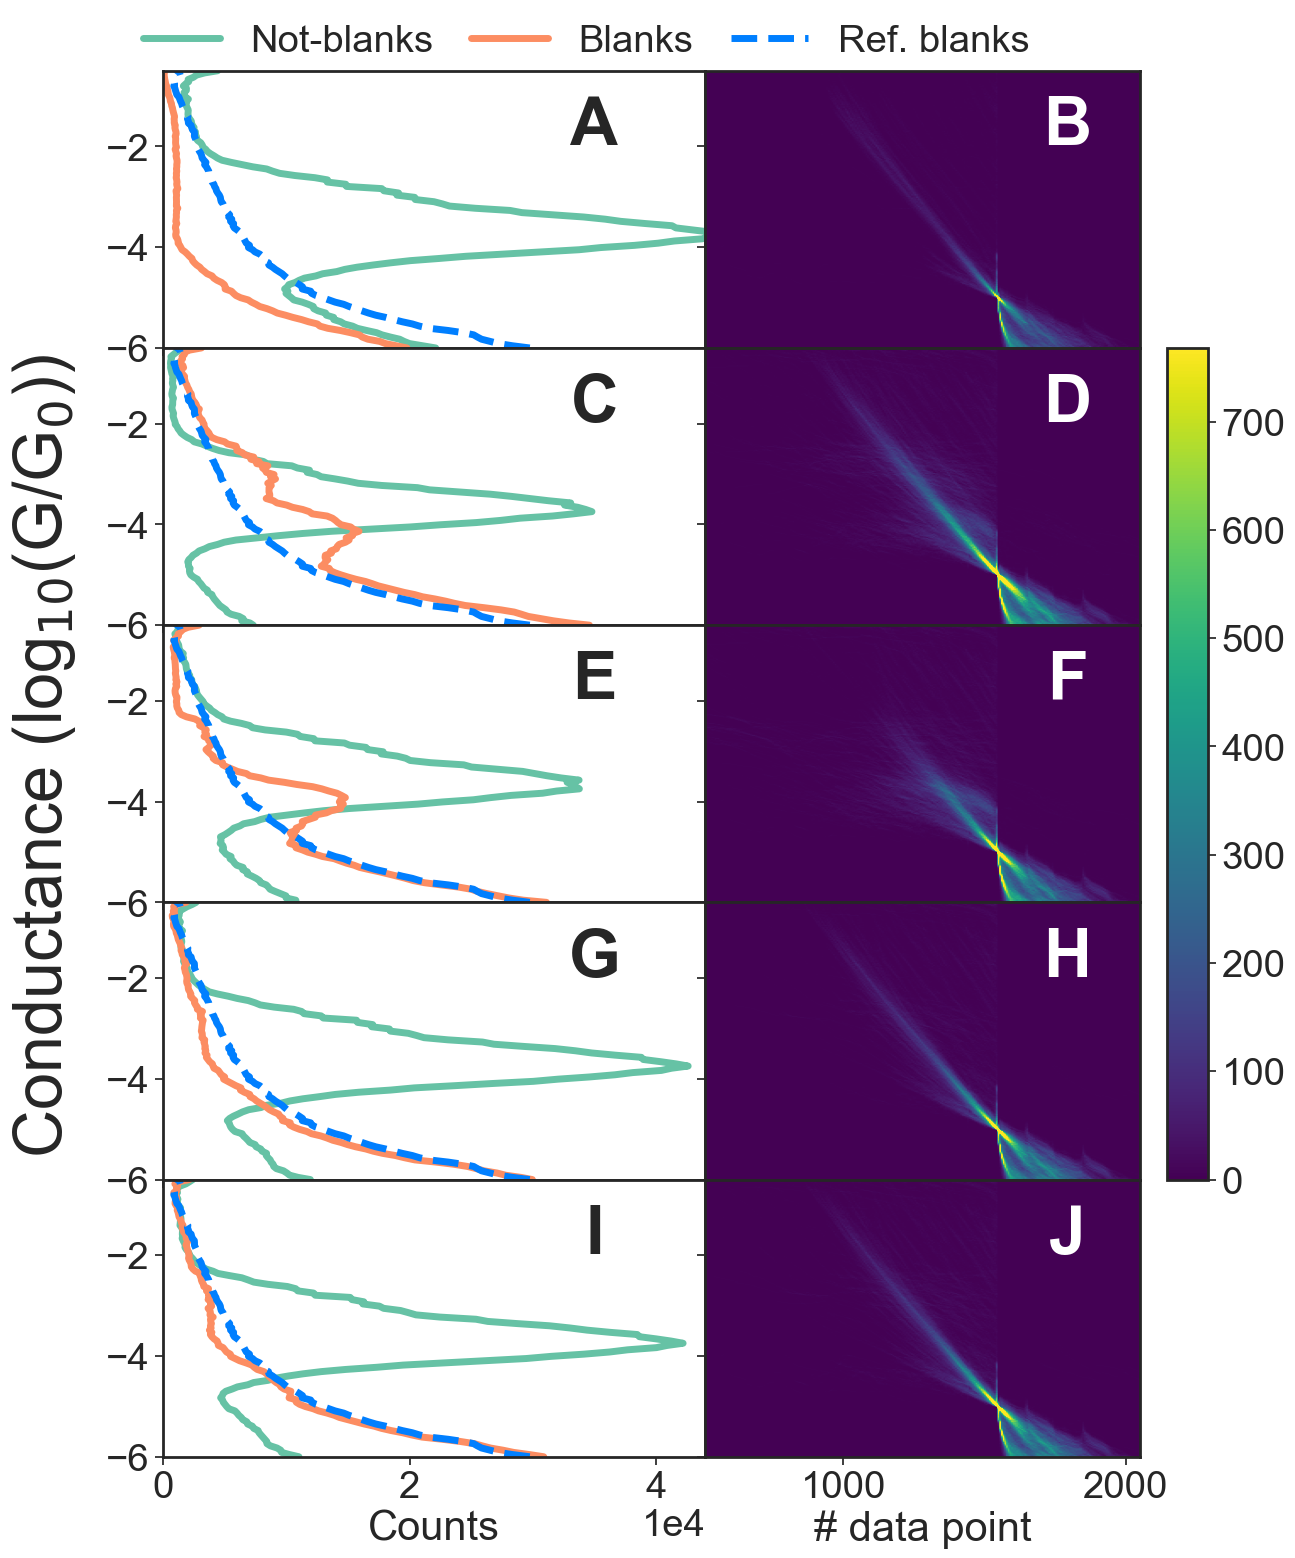

In [30]:
from sklearn import metrics

tunneling_label = 1
max_ax1 = 0
n_clusters = 2
fig, ax = plt.subplots(5, 2, figsize=(14, 18))
fig.subplots_adjust(hspace=0, wspace=0)
ax1_yaxis = np.linspace(pre_info.plot_low, pre_info.plot_high, pre_info.bins)
for idx, m in enumerate(cluster_labels):
    sums = []
    for l in np.unique(m):
        extracted = full_hists[m == l]
        sums.append(np.sum(extracted)/len(extracted))
    
    max_sum = np.argmax(sums)
    pred_mol = full_hists[m == max_sum]
    pred_tun = full_hists[m != max_sum]

    ax[idx, 0].plot(
        pred_mol.sum(axis=0),
        ax1_yaxis,
        label=f"Not-blanks" if idx == 0 else ""
    )
    ax[idx, 0].plot(
        pred_tun.sum(axis=0),
        ax1_yaxis,
        label=f"Blanks" if idx == 0 else ""
    )
    ax[idx, 0].plot(
        full_hists[labels == 1].sum(axis=0),
        ax1_yaxis,
        c=c[0],
        linestyle="--",
        label="Ref. blanks" if idx == 0 else "",
    )

    m[m != max_sum] = n_clusters + 1
    m[m == max_sum] = -1
    m[m == (n_clusters + 1)] = 1

    im = plot_2dhist(m, tunneling_label, bins_2d=(256, 256), ax=ax[idx, 1], hist2d_length=2048)

    print(f"Amount predicted blanks: {len(pred_tun)}")

    print(
        f"Fowlkes-mallows: {metrics.fowlkes_mallows_score(labels, m)*100:.3}"
    )
    acc = metrics.accuracy_score(labels, m)
    m = np.abs(m - 1)  # flip labels
    flipped_acc = metrics.accuracy_score(labels, m)

    print(
        f"Accuracy: {max(acc, flipped_acc)*100:.3}"
    )

    if np.max(pred_mol.sum(axis=0)/len(pred_mol)) > max_ax1:
        max_ax1 = np.max(pred_mol.sum(axis=0)/len(pred_mol))
    
    ax[idx, 1].set_yticklabels([])
    if idx < 4:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
    ax[idx, 0].set_ylim(pre_info.plot_low, pre_info.plot_high)
ax[0, 0].legend(frameon=False, loc="lower left", bbox_to_anchor=(-0.1, 0.92, 1, 0), ncol=3, columnspacing=1.)

for idx in np.arange(len(ax[:, 0])):
    ax[idx, 0].text(
        35_000, -1.6, ALPHABET[idx*2], va="center", ha="center", size=FONTSIZE, weight="bold"
    )
    ax[idx, 1].text(
        2048 - 256, -1.6, ALPHABET[idx*2 + 1], va="center", ha="center", size=FONTSIZE, weight="bold", color="white"
    )
    ax[idx, 0].set_xlim(0, 44_000)
ax[-1, 0].ticklabel_format(axis="x", scilimits=[-5, 4])

fig.colorbar(im, ax=ax[:, 1], shrink=.6)
fig.text(0.04, 0.5, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)
ax[-1, 0].set_xlabel("Counts")
ax[-1, 1].set_xlabel("# data point")
fig.savefig("./clustering_2clusters.pdf")
plt.show()